# Introduction

Passing accuracy has always been the most common evaluation tool for how good a passer a player is. But everyone who watches football knows that the simple passing percentages are deeply flawed at best and completely meaningless at worst. Of course a player who always picks safe passing options will have a higher passing success rate, but does that mean he's a good passer of the ball? Does that mean he can actually make a difference?

This would be a problem for people trying to analyse the game, and for clubs trying to recruit players that fit a certain passing profile. Passing is an extremely important part of the game, it's the most common action, yet our way of evaluating passes (especially outside the final third) is very simplistic. 

We need a way to assess how "difficult" a pass is, players can pass the ball around the back with no pressure at all and have a 100% success rate, but knowing that doesn't sound too useful. It's actually misleading. 

### Some Basics About Passing
- Long passes are harder to complete than short simple passes.
- The closer you are to the opposition goal, the harder it is to complete a pass.
- Vertical passes are harder to complete.
- Line-breaking passes (number of opponents in the way) are harder to complete.

Those are just some of the basics that everyone who's ever watched a game of football can agree on, yet when we analyse passes we treat them all equally. *Enters the expected passing model!!*

# Expected Passing

Inspired by the famous Expected Goals model, we'll build an Expected Passing models to get a better evaluation of our passes. Which passes are hard to complete and which ones are simple? That way, when we're analysing passing we have a better way of assessing them, based on how difficult it is to pull a certain pass off.

### The Idea
The idea is simple, we have a lot of historical data about passes. We use this data to create a model that tells us the probability of a pass being completed (in other words, how difficult a pass is) based on a lot of feautures.

This model takes into account the starting position of a pass, the ending position of a pass, and the type of pass (simple, long, header, cross, launch, etc).

There are lots of other factors we could've taken into account, but we're limited by the data available. There's also potential for more specific models we could develop using the same idea. But we'll just start with this basic model.

#### We use *Wyscout's* data for the EPL's 2018 season that they've generously made available for free.
 

In [1]:
# libraries and stuff
import json
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# 1. Import the Data

In [2]:
# function for getting event data from files
def get_event(leagues, event_name):
    # empty df
    raw_data = pd.DataFrame()
    
    # loop over the leagues and append data to the df
    for league in leagues:
        path = '../data/Wyscout/events/events_{}'.format(league) + '.json'
        with open(path, encoding='utf-8') as f:
            temp = json.load(f)
        temp_df = pd.DataFrame(temp)
        raw_data = raw_data.append(temp_df)
    
    # subset the event and return
    event_df = raw_data[raw_data['eventName'] == event_name]
    return event_df

In [3]:
# get passing data for the PL
# leagues = ['England', 'France', 'Germany', 'Italy', 'Spain', 'European_Championship', 'World_Cup']
leagues = ['England']
df_pass = get_event(leagues, 'Pass')
df_pass.reset_index(inplace=True, drop=True)

# 2. Build the Model

In [4]:
xp_model = pd.DataFrame()

xp_model['label'] = df_pass['tags'].astype('str').str.contains('1801').astype(int) 
xp_model['x1'] = df_pass['positions'].str[0].str['x']
xp_model['y1'] = df_pass['positions'].str[0].str['y']
xp_model['x2'] = df_pass['positions'].str[1].str['x']
xp_model['y2'] = df_pass['positions'].str[1].str['y']
xp_model['pass_type'] = df_pass['subEventName']

In [5]:
# make sure there aren't any missing values
xp_model.isna().sum()

label        0
x1           0
y1           0
x2           0
y2           0
pass_type    0
dtype: int64

In [6]:
features_list = ['x1', 'y1', 'x2', 'y2', 'pass_type']
X = xp_model[features_list]
y = xp_model['label']

In [7]:
print(xp_model.shape)
print(X.shape)
print(y.shape)

(328657, 6)
(328657, 5)
(328657,)


In [8]:
# Encode categorical variable
ohe = OneHotEncoder(sparse=False)
column_trans = make_column_transformer(
    (OneHotEncoder(), ['pass_type']),
    remainder='passthrough')
column_trans.fit_transform(X)

array([[ 0.,  0.,  0., ..., 49., 31., 78.],
       [ 0.,  0.,  0., ..., 78., 51., 75.],
       [ 0.,  0.,  1., ..., 75., 35., 71.],
       ...,
       [ 0.,  0.,  0., ..., 70., 53., 89.],
       [ 0.,  0.,  0., ..., 89., 99., 72.],
       [ 1.,  0.,  0., ..., 72.,  0.,  0.]])

In [9]:
# instantiate the model
clf = RandomForestClassifier(n_jobs=2, random_state=0)
pipe = make_pipeline(column_trans, clf)

In [10]:
# cross validate the model
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.8596256816053301

In [11]:
# compare to null accuracy
y.value_counts(normalize=True)

1    0.82542
0    0.17458
Name: label, dtype: float64

In [12]:
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['pass_type'])],
                                   verbose=False)),
                ('randomforestclassifier',
                 Rando...trap=True, ccp_alpha=0.0,
                                        class_weig

In [13]:
# add the probability of completing the pass
proba = pipe.predict_proba(X)
xp_model['xP'] = proba[:, 1]

In [14]:
# add player id
xp_model['player_id'] = df_pass['playerId']

In [15]:
xp_model.head()

,label,x1,y1,x2,y2,pass_type,xP,player_id
0,1,49,49,31,78,Simple pass,1.00,25413
1,1,31,78,51,75,High pass,0.91,370224
2,1,51,75,35,71,Head pass,0.89,3319
3,1,35,71,41,95,Head pass,0.90,120339
4,1,41,95,72,88,Simple pass,0.82,167145


# 3. Prepare data for analysis

In [16]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
# function to fix encoding
def fix_name(name):
    return name.encode('ascii', 'strict').decode('unicode-escape')

In [18]:
# loading players data
path = '../data/Wyscout/players.json'
with open(path, encoding='utf-8') as f:
    data = json.load(f)

players_raw = pd.DataFrame(data)

In [19]:
# get relevant columns
players_df = players_raw[['wyId', 'shortName', 'birthDate', 'role']]

In [20]:
# clean the row column
for i in players_raw.index:
    players_df.at[i, 'role'] = players_raw['role'][i]['code3']

In [21]:
players_df.head()

,wyId,shortName,birthDate,role
0,32777,H. Tekin,1989-06-17,GKP
1,393228,M. Sarr,1999-01-23,DEF
2,393230,O. Mandanda,1998-10-26,GKP
3,32793,A. N'Diaye,1990-03-06,MID
4,393247,I. Konat\u00e9,1999-05-25,DEF


In [22]:
# add players name to the xp_model df
xp_model = pd.merge(xp_model, players_df, left_on='player_id', right_on='wyId')

In [23]:
# subset relevant features for final analysis
analysis_features = ['label', 'xP', 'shortName', 'role']
df_analysis = xp_model[analysis_features]

In [24]:
df_analysis.shape

(328651, 4)

In [25]:
no_passes = df_analysis['shortName'].value_counts().rename('passes')
no_passes = pd.DataFrame(no_passes)
df_analysis = pd.merge(df_analysis, no_passes, left_on='shortName', right_on=no_passes.index)
df_analysis.shape

(328651, 5)

In [26]:
df_analysis.head()

,label,xP,shortName,role,passes
0,1,1.00,A. Lacazette,FWD,657
1,0,0.19,A. Lacazette,FWD,657
2,0,0.01,A. Lacazette,FWD,657
3,1,0.98,A. Lacazette,FWD,657
4,1,0.97,A. Lacazette,FWD,657


In [27]:
df_analysis['xP'].mean()

0.8244680139538467

# 4. Analyse data (df_analysis)

First, we'll subset our df to consider only players with over 250 passes.

In [28]:
# players with over 250 passes
over_250 = df_analysis[df_analysis['passes'] >= 250]

## 4.1 Passing Attempts

Let's look at players who attempt the safest passes on average.

In [29]:
safe_attempt = over_250.groupby('shortName').agg({'xP': 'mean', 'role': 'first'}).sort_values(by='xP', ascending=False).reset_index().head(20)
safe_attempt['shortName'] = safe_attempt['shortName'].apply(fix_name)

In [30]:
safe_attempt.tail()

,shortName,xP,role
15,A. Laporte,0.912176,DEF
16,J. Matip,0.907059,DEF
17,Fernandinho,0.907012,MID
18,G. Wijnaldum,0.906464,MID
19,D. Lovren,0.903512,DEF


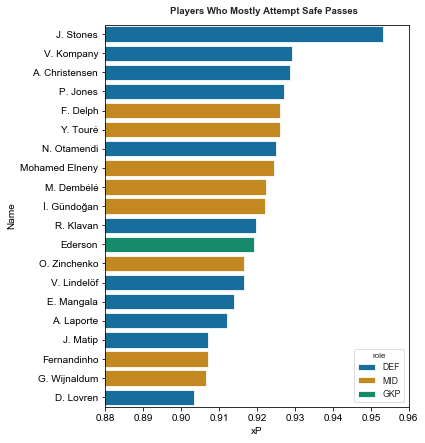

In [31]:
# set a palette
viz_pal = "colorblind"

fig, ax = plt.subplots(figsize=(6,6))
sns.set_style("white")
sns.set_context('paper')
ax = sns.barplot(x="xP", y="shortName", data=safe_attempt, palette=viz_pal, hue='role', dodge=False)
ax.set(xlim=(0.88, 0.96))
plt.ylabel('Name')
fig.text(0.4, 1, 'Players Who Mostly Attempt Safe Passes', fontweight='bold')
plt.tight_layout()

plt.savefig("01_safe_attempts.png", dpi=300, bbox_inches="tight")

### Observations

- Defenders and defensive midfielders usually attempt safe passes which makes sense. Another interesting thing to notice is that a lot of Man City players appear in this list, which also makes sense considering their style of play that mostly depends on short passing and playing out from the back.

- Most goalkeepers play longer (more difficult) passes, but Ederson is the only GK that appears on this list, again Pep's well known style of playing out from the back.

- No forwards appear on the list which makes sense because passes in the final third are more difficult to complete.

Now let's look at players who, on average, attempt more difficult passes.

In [32]:
risky_attempt = over_250.groupby('shortName').agg({'xP': 'mean', 'role': 'first'}).sort_values(by='xP', ascending=True).reset_index().head(20)
risky_attempt['shortName'] = risky_attempt['shortName'].apply(fix_name)

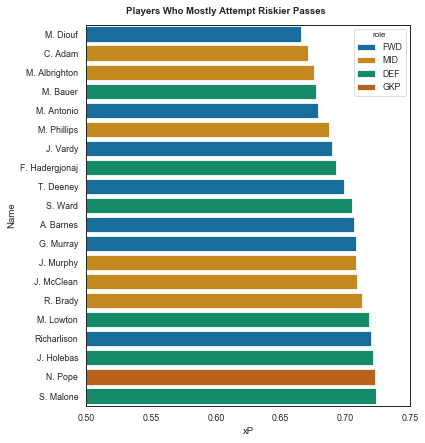

In [33]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set_style("white")
sns.set_context('paper')
ax = sns.barplot(x="xP", y="shortName", data=risky_attempt, palette=viz_pal, hue='role', dodge=False)
ax.set(xlim=(0.5, 0.75))
plt.ylabel('Name')
fig.text(0.3, 1, 'Players Who Mostly Attempt Riskier Passes', fontweight='bold')
plt.tight_layout()

plt.savefig("02_risky_attempts.png", dpi=300, bbox_inches="tight")

### Observations:
- Naturally, more forwards and attacking midfielders appear on this list because attempting a pass higher up the pitch is more difficult than passing it around the back.
- The defenders that appear on this list mostly play for teams in the bottom half of the table, which tells us more about their style of play. Bigger teams tend to play out from the back so they pass it around the back more often than smaller teams that tend to play more direct passes from the back.

This analysis could be expanded to start looking at specific teams and analyse their style of play.

## 4.2 Difficult Passes Completed

Now let's look at completed difficult passes. But first, we need to define what a "difficult pass" is. 

We'll specify a certain threshold, and if a pass's xP value is below that threshold we'll count that pass as difficult. We'll use the mean of all xP values in our dataset as the threshold.

In [34]:
# define the threshold to be the mean of the xP values in our dataset
threshold = over_250['xP'].mean()

# subset our df to get our completed difficult passes only
above_av = over_250[(over_250['xP'] < threshold) & (over_250['label'] == 1)]
above_av.head()

,label,xP,shortName,role,passes
64,1,0.73,A. Lacazette,FWD,657
66,1,0.81,A. Lacazette,FWD,657
77,1,0.56,A. Lacazette,FWD,657
122,1,0.70,A. Lacazette,FWD,657
136,1,0.80,A. Lacazette,FWD,657


In [35]:
above_av_count = above_av.groupby('shortName').agg({'label': 'count', 'role': 'first', 'passes': 'first'})\
                    .sort_values(by='label', ascending=False).reset_index()

# fix the encoding of the names
above_av_count['shortName'] = above_av_count['shortName'].apply(fix_name)

# add percentage of diff passes
above_av_count['rate'] = (above_av_count['label'] / above_av_count['passes']) * 100

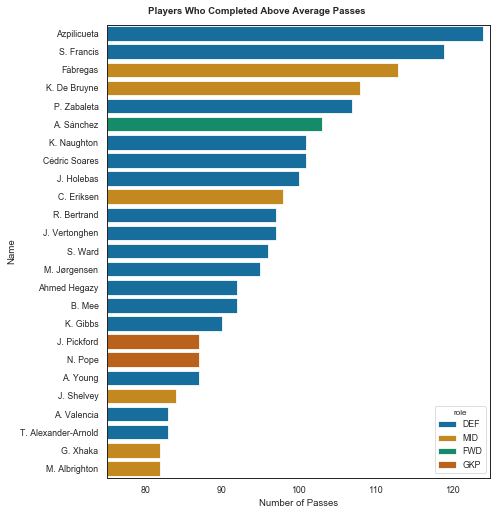

In [36]:
fig, ax = plt.subplots(figsize=(7,7))
sns.set_style("white")
sns.set_context('paper')
ax = sns.barplot(x="label", y="shortName", data=above_av_count.head(25), palette=viz_pal, hue='role', dodge=False)
ax.set(xlim=(75, 125))
plt.xlabel('Number of Passes')
plt.ylabel('Name')
fig.text(0.3, 1, 'Players Who Completed Above Average Passes', fontweight='bold')
plt.tight_layout()

plt.savefig("03_difficult_passes_comp_players.png", dpi=300, bbox_inches="tight")

### Observations:

- Again, we can see a lot of defenders from bottom-half teams, a lot of those teams play a style that depends on long passes which are harder to complete.
- A lot of full backs also appear on this list, probably because they complete a lot of crosses.
- It's interesting that Xhaka and Shelvey because they usually play a deeper role in midfield, which tells us they attempt a lot of vertical and longer passes which, again, agrees with the eye test.
- Fabregas and KDB are really high up, which is not really surprising.

A lot of those long passes played by defenders and GKs from bottom half teams end up in a 50/50 situation. So let's only consider MID's and FWD's in our analysis. 

In [37]:
# subset our df to get only MID's and FWD's
roles_to_consider = ['MID', 'FWD']
fwd_mid = above_av_count[above_av_count['role'].isin(roles_to_consider)]

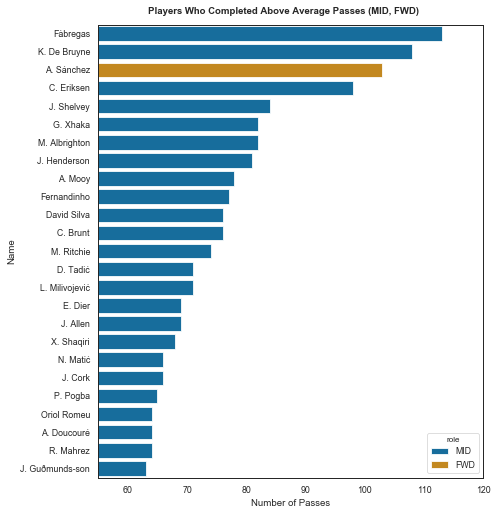

In [38]:
fig, ax = plt.subplots(figsize=(7,7))
sns.set_style("white")
sns.set_context('paper')
ax = sns.barplot(x="label", y="shortName", data=fwd_mid.head(25), palette=viz_pal, hue='role', dodge=False)
ax.set(xlim=(55, 120))
plt.xlabel('Number of Passes')
plt.ylabel('Name')
fig.text(0.3, 1, 'Players Who Completed Above Average Passes (MID, FWD)', fontweight='bold')
plt.tight_layout()

plt.savefig("04_fwd_mid_diff_count.png", dpi=300, bbox_inches="tight")

### Observations
- The list passes the eye test for the most part, apart from maybe a few players like Henderson and Dier (might be worth looking into). 
- Another interesting thing to note here is most of those players are from 'big teams' and only one forward (Sanchez who often played deeper for Arsenal that season). Midfielders and bigger teams tend to make a lot more passes than weaker teams, so next we're gonna look at the % of difficult passes considering the number of passes a player makes, which should give us more players from bottom half teams and more forwards.

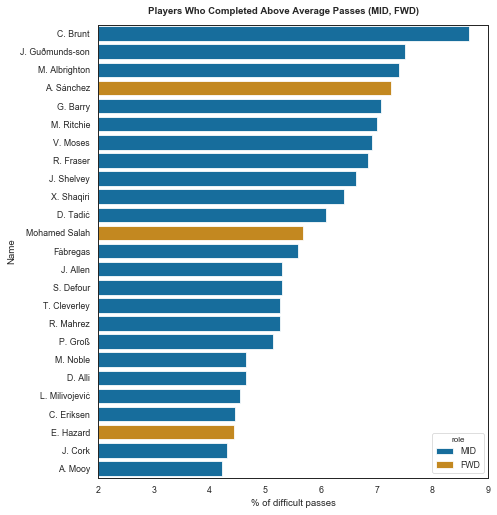

In [39]:
fig, ax = plt.subplots(figsize=(7,7))
sns.set_style("white")
sns.set_context('paper')
ax = sns.barplot(x="rate", y="shortName", 
                 data=fwd_mid[fwd_mid['label'] >= 50].sort_values(by='rate', ascending=False).head(25), 
                 palette=viz_pal, hue='role', dodge=False)
ax.set(xlim=(2, 9))
plt.xlabel('% of difficult passes')
plt.ylabel('Name')
fig.text(0.3, 1, 'Players Who Completed Above Average Passes (MID, FWD)', fontweight='bold')
plt.tight_layout()

plt.savefig("04_fwd_mid_diff_rate.png", dpi=300, bbox_inches="tight")

### Observations
- Now we get more players from bottom half teams.
- Alexis Sanchez still pretty high up, which shows how brilliant he was that season. His contribution wasn't only about scoring goals.
- *A lot* of wingers appear on this list, due to crossing. Might be interesting to break down the roles further if we're interested in a certain type of players.

Now let's examine the *actual passing success rate* for the players vs *the expected passing success rate*.

In [40]:
agg_dic = {'label': 'sum', 'passes': 'first', 'xP': 'mean', 'role': 'first'}
rename_dic = {'shortName': 'player', 'label': 'successful passes', 'passes': 'total'}
xp_actual = over_250.groupby('shortName').agg(agg_dic).reset_index().rename(columns=rename_dic)
xp_actual['succes rate'] = xp_actual['successful passes'] / xp_actual['total']
xp_actual['xP_diff'] = (xp_actual['succes rate'] - xp_actual['xP']) * 100
xp_actual['player'] = xp_actual['player'].apply(fix_name)

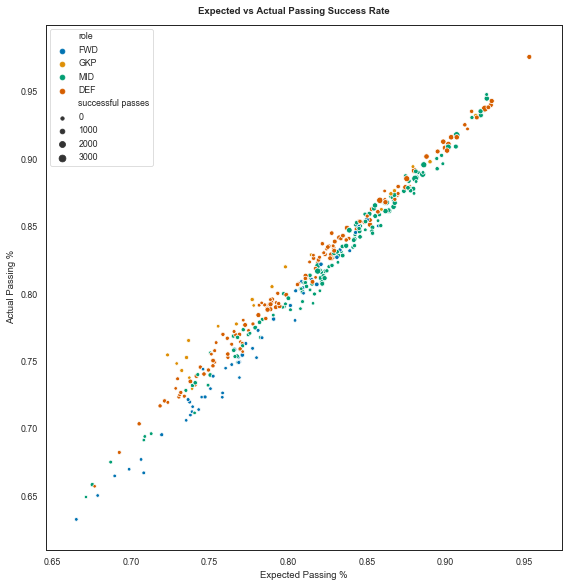

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
sns.set_style("white")
sns.set_context('paper')
ax = sns.scatterplot(x="xP", y="succes rate", data=xp_actual, 
                 palette=viz_pal, hue='role', size='successful passes')

plt.xlabel('Expected Passing %')
plt.ylabel('Actual Passing %')
fig.text(0.35, 1, 'Expected vs Actual Passing Success Rate', fontweight='bold')
plt.tight_layout()

plt.savefig("05_actual_vs_exp.png", dpi=300, bbox_inches="tight")

# 5. Final Thoughts

A lot of the results pass the eye test, but the model is clearly far from perfect and there's a lot of room for improvements. 

It could definitely use more detailed data that would take into account some other factors like:
- Opposition players pressuring the player taking the pass
- Whether the pass was taken by the weak or strong foot of the player
- Information about the attacking situation (a pass taken during a counter attack is more difficult)
- The context of a pass is important, like attempting a pass after a dribble for example
- The game state (whether the team is losing or winning)
- The pass angle
- More data

The analysis done here is only a small part of how we could apply this model. One other interesting idea it could be used for is to analyse a team's playing style in more details. 

Another interesting thing that came to mind while looking at the final results is to compare a player's style playing under different managers. For example, my analysis shows that Yaya Torue mostly plays safe passes, my theory is it's due to Pep Guardiola's arrival at Man City. In earlier seasons Yaya played a lot of difficult passes. This theory could be tested if we have data from earlier seasons.

### A note on distance as a feature
Intuitively, passing distance is a very important factor regarding whether a pass will be successful or not. But the problem with it is that for most incomplete passes we don't get an accurate estimate of the distance of the pass. 

The data we have only accounts for where the pass actually ends up, not where it was intended to go. For this reason, I chose to leave the distance out. 

# Bonus: Alexis Sanchez

One of the stand out players while doing this analysis was Alexis Sanchez. So let's plot his completed 'risky' passes. Again, we define risky as having xP below the average in our dataset.

In [42]:
sanchez_id = 3361
col_list = ['label', 'x1', 'y1', 'x2', 'y2', 'pass_type', 'xP']
sanchez = xp_model[xp_model['wyId'] == sanchez_id][col_list].reset_index(drop=True)
sanchez_diff = sanchez[(sanchez['xP'] < 0.8) & (sanchez['label'] == 1)]

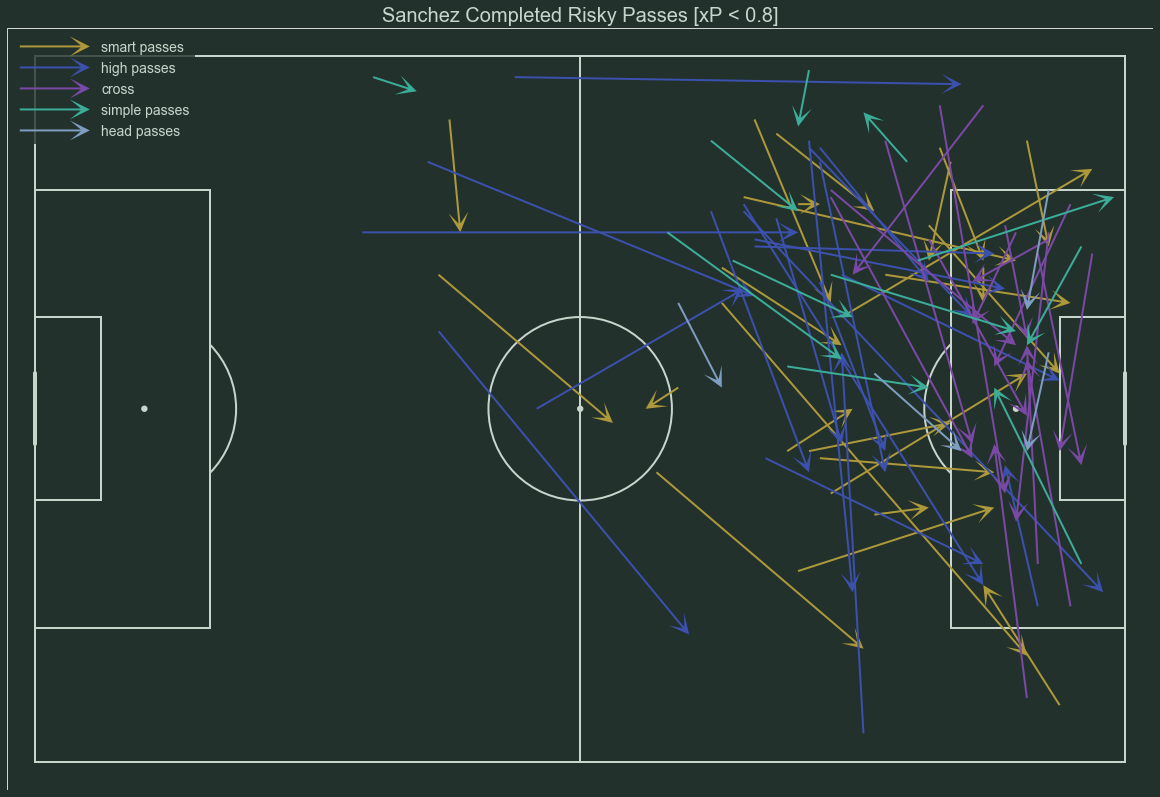

In [43]:
from mplsoccer.pitch import Pitch
from matplotlib import rcParams
rcParams['text.color'] = '#c7d5cc' 

# PLOT SANCHEZ COMPLETED DIFF PASSES
pitch = Pitch(pitch_type='wyscout', orientation='horizontal',
              pitch_color='#22312b', line_color='#c7d5cc', figsize=(16, 11),
              constrained_layout=True, tight_layout=False)
fig, ax = pitch.draw()

# Plot the smart passes
pitch.arrows(sanchez_diff[sanchez_diff['pass_type'] == 'Smart pass']['x1'], sanchez_diff[sanchez_diff['pass_type'] == 'Smart pass']['y1'],
             sanchez_diff[sanchez_diff['pass_type'] == 'Smart pass']['x2'], sanchez_diff[sanchez_diff['pass_type'] == 'Smart pass']['y2'], width=2,
             headwidth=10, headlength=10, color='#ad993c', ax=ax, label='smart passes')

# Plot the high passes
pitch.arrows(sanchez_diff[sanchez_diff['pass_type'] == 'High pass']['x1'], sanchez_diff[sanchez_diff['pass_type'] == 'High pass']['y1'],
             sanchez_diff[sanchez_diff['pass_type'] == 'High pass']['x2'], sanchez_diff[sanchez_diff['pass_type'] == 'High pass']['y2'], width=2,
             headwidth=10, headlength=10, color='#3C50AD', ax=ax, label='high passes')

# Plot the crosses
pitch.arrows(sanchez_diff[sanchez_diff['pass_type'] == 'Cross']['x1'], sanchez_diff[sanchez_diff['pass_type'] == 'Cross']['y1'],
             sanchez_diff[sanchez_diff['pass_type'] == 'Cross']['x2'], sanchez_diff[sanchez_diff['pass_type'] == 'Cross']['y2'], width=2,
             headwidth=10, headlength=10, color='#7a49a5', ax=ax, label='cross')

# Plot the simple passes
pitch.arrows(sanchez_diff[sanchez_diff['pass_type'] == 'Simple pass']['x1'], sanchez_diff[sanchez_diff['pass_type'] == 'Simple pass']['y1'],
             sanchez_diff[sanchez_diff['pass_type'] == 'Simple pass']['x2'], sanchez_diff[sanchez_diff['pass_type'] == 'Simple pass']['y2'], width=2,
             headwidth=10, headlength=10, color='#3CAD99', ax=ax, label='simple passes')

# Plot the head passes
pitch.arrows(sanchez_diff[sanchez_diff['pass_type'] == 'Head pass']['x1'], sanchez_diff[sanchez_diff['pass_type'] == 'Head pass']['y1'],
             sanchez_diff[sanchez_diff['pass_type'] == 'Head pass']['x2'], sanchez_diff[sanchez_diff['pass_type'] == 'Head pass']['y2'], width=2,
             headwidth=10, headlength=10, color='#7F9DC0', ax=ax, label='head passes')

# setup the legend
ax.legend(facecolor='#22312b', handlelength=5, edgecolor='None', fontsize=14, loc='upper left')

# Set the title
ax.set_title('Sanchez Completed Risky Passes [xP < 0.8]', fontsize=20)

# Set the figure facecolor
fig.set_facecolor('#22312b')

# save fig
plt.savefig("06_sanchez.png", dpi=300, bbox_inches="tight")